In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from math import ceil
from plotly.subplots import make_subplots
import statsmodels.tsa.stattools as stattools

In [2]:
data = pd.read_csv('../data/processed-flight-data.csv')
data.head()

,from_airport_code,dest_airport_code,aircraft_type,airline_number,airline_name,duration,stops,price
0,13,70,865,20,502,2145,2,1952.0
1,5,52,1879,43,813,730,1,825.0
2,12,30,707,70,1269,565,1,637.0
3,23,74,1066,83,784,1275,2,2747.0
4,4,70,1609,83,405,2036,3,1604.0


In [3]:
corr = data.corr()

ax_names = [f"{v}" for v in corr.columns]
corr.index = ax_names
corr.columns = ax_names

mask = np.triu(np.ones_like(corr, dtype=bool))

fig_c = go.Figure(go.Heatmap(z=corr.mask(mask),
                            x=ax_names,
                            y=ax_names,
                            colorscale=px.colors.diverging.RdBu,
                            reversescale=True,
                            zmin=-1,
                            zmax=1,
                            hoverongaps=False,
                            hovertemplate='Correlation: %{z:.2f}<br>'))

fig_c.update_layout(xaxis=dict(scaleanchor="y"), yaxis_autorange='reversed')
fig_c.update_layout(autosize=False, width=1000, height=1000,
                    font=dict(size=18), hoverlabel=dict(font=dict(size=18)))

fig_c.show()

## Linear Correlations - Correlation Matrix
We see that the only significant correlation is `stops` - duration which is to be expected. however none of the columns are linearly correlated to the `price` variable 

In [4]:
values = corr.values
rows, cols = np.where(((np.abs(values) > 0.4) & (np.abs(values) < 1)))

idxs = np.where(rows < cols)
rows = rows[idxs]
cols = cols[idxs]

index = pd.MultiIndex.from_arrays([corr.index[rows], corr.columns[cols]])

result = pd.DataFrame(data=[corr.iloc[x, y] for x, y in zip(rows, cols)], index=index, columns=['Correlation'])
result

Correlation
airline_number stops     0.409577
duration       stops     0.562220
               price     0.430250

## Multiple correspondence analysis (MCA)

Due to our lack of numerical columns we will use MCA.

In [5]:
from mca import MCA


mca_model = MCA(data[['from_airport_code', 'dest_airport_code', 'aircraft_type', 'airline_number', 'airline_name']], benzecri=False, TOL=1e-4)

# Access the results, including coordinates for rows and columns
row_coordinates = mca_model.fs_r(N=2)  # Row coordinates for the first 3 dimensions
column_coordinates = mca_model.fs_c(N=2)  # Column coordinates for the first 3 dimensions
explained_variance = mca_model.expl_var(greenacre=False)

print(row_coordinates, column_coordinates, explained_variance)

[[ 0.01233054 -0.07395934]
 [ 0.15999362  0.07199277]
 [-0.53339125  0.09406051]
 ...
 [-0.36246207  0.08045534]
 [ 0.31283048 -0.31792755]
 [-0.91638402 -0.03808317]] [[-0.08733057 -0.46984917]
 [-0.16863469 -0.68717623]
 [ 0.31921105  0.02188636]
 [-0.2242362  -0.51727955]
 [-0.50131007  0.05947476]] [8.21757916e-01 1.14732787e-01 4.20764156e-02 2.14328813e-02
 1.08350335e-31]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


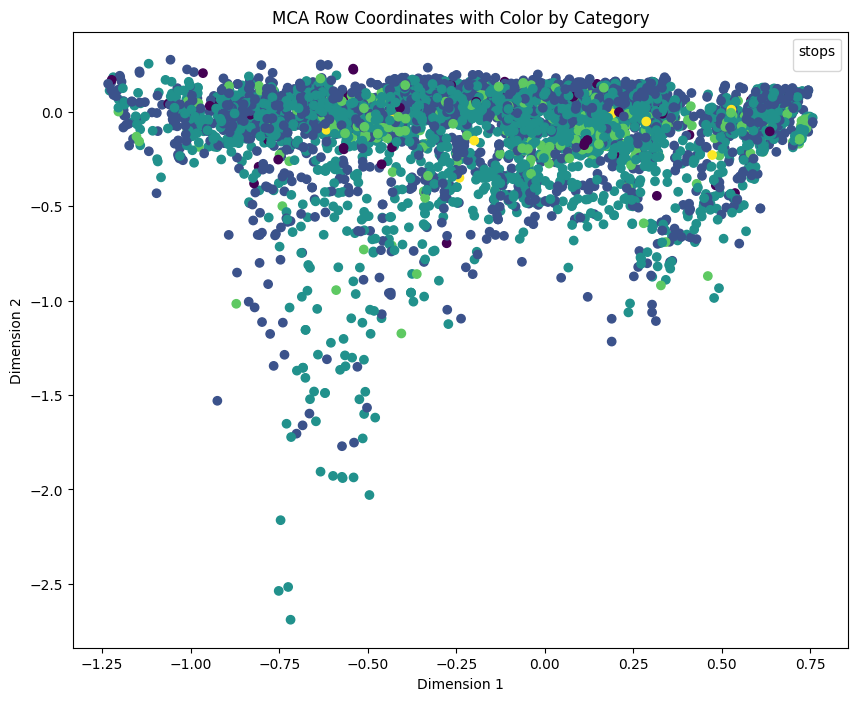

In [6]:
import matplotlib.pyplot as plt 
# Assuming 'data_encoded' is the original DataFrame with encoded categorical features
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Adjusting the third dimension (z) in the scatter plot
ax.scatter(row_coordinates[:, 0], row_coordinates[:, 1], c=data['stops'], cmap='viridis')

ax.set_title('MCA Row Coordinates with Color by Category')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title='stops')

plt.show()

We saw through experimentation that the categorical data are not that correlated individually, it is when we combine them that we get a better correlation. We will therefore could combine the categorical data into one column for better correlation.